**Name:** Sampreeth Avvari

**NetID:** spa9659

**Text as Data HW 3**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pyLDAvis --use-deprecated=legacy-resolver

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
import re

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
nltk.download('stopwords')
nltk.download('punkt')

from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.similarities import MatrixSimilarity
import gensim.downloader as api
from gensim.models import HdpModel
from gensim.models import LsiModel

from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Question 1

In [4]:
election_tweets = pd.read_csv('/content/drive/MyDrive/TAD/HW3_data/electiontweets.csv', index_col=False)
election_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,hashtag,date,postelection
0,2020-10-31 14:15:00,1.322543e+18,#Opinion| Donald #Trump’s #Economy Really was ...,1,0,TweetDeck,donaldtrump,2020-10-31,0
1,2020-10-29 00:42:03,1.321613e+18,#MikePence and #DonaldTrump both! https://t.co...,0,0,Twitter Web App,donaldtrump,2020-10-29,0
2,2020-10-28 16:11:23,1.321485e+18,"So how's that winning going for you, #Trump su...",0,0,Twitter for Android,donaldtrump,2020-10-28,0
3,2020-11-05 21:34:42,1.324465e+18,So the #GOP are now giving #Trump in his momen...,2,2,Twitter for iPad,donaldtrump,2020-11-05,1
4,2020-11-05 19:41:00,1.324437e+18,Lets see #Election2020 Results dont be a surpr...,0,0,Twitter for Android,donaldtrump,2020-11-05,1


### 1.A

In [5]:
hashtags_summary = election_tweets.groupby(['hashtag','date']).agg({
    'tweet': lambda tweets: " ".join(tweets),
    'source': 'count'
}).reset_index()

summary_stats = hashtags_summary.groupby('hashtag').agg({
    'date': 'count',
    'source': 'sum'
}).reset_index().rename(columns={'date': 'days', 'source': 'no_of_tweets'})

summary_stats


,hashtag,days,no_of_tweets
0,donaldtrump,25,20000
1,joebiden,26,20000


### 1.B

In [6]:
election_tweets['tweet']

0        #Opinion| Donald #Trump’s #Economy Really was ...
1        #MikePence and #DonaldTrump both! https://t.co...
2        So how's that winning going for you, #Trump su...
3        So the #GOP are now giving #Trump in his momen...
4        Lets see #Election2020 Results dont be a surpr...
                               ...                        
39995    Oh, just me and the President-Elect of the Uni...
39996    You know, the damned idiot,Joe #biden didnt ma...
39997    @GMB @richardgaisford #Elections2020 heres my ...
39998    Luckily when #Biden becomes president he will ...
39999    What in the actual hell did he just say?? I li...
Name: tweet, Length: 40000, dtype: object

In [7]:
def preprocess_election_tweets(tweet):
    tweet_text = re.sub(r'https|http|rt|t\.co', '', tweet)
    tweet_text = re.sub(r'[0-9]', ' ', tweet_text)
    tweet_text = tweet_text.translate(str.maketrans('', '', string.punctuation)).lower()
    tokens = word_tokenize(tweet_text)
    stop_words = stopwords.words("english")
    tokens = [word for word in tokens if word.isascii() and word not in stop_words and len(word) > 1]
    return " ".join(tokens)

election_tweets['preprocessed_tweet'] = election_tweets['tweet'].apply(preprocess_election_tweets)


In [8]:
election_vectorizer = CountVectorizer()
election_dtm = election_vectorizer.fit_transform(election_tweets['preprocessed_tweet'])
election_vocab = election_vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(election_dtm.toarray(), columns=election_vocab, index=range(len(election_tweets['preprocessed_tweet'])))
dtm_df

,aa,aaa,aaaaargh,aaas,aab,aabxyqurp,aacb,aacckcelas,aacdpyvit,aaceludud,...,zzrj,zztlhq,zztop,zztqeaqi,zzuzvzmbw,zzv,zzvqwgnvjl,zzwld,zzwptc,zzylk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
election_tweets['preprocessed_tweet']

0        opinion donald trump economy really better oba...
1                             mikepence donaldtrump qw drm
2               hows winning going trump suppoers duocc td
3        gop giving trump moment desperation silent tre...
4        lets see election results dont surprise like m...
                               ...                        
39995    oh presidentelect united states presidentelect...
39996    know damned idiotjoe biden didnt make decision...
39997    gmb richardgaisford elections heres paintings ...
39998    luckily biden becomes president understand lxr...
39999    actual hell say listened xs still clue gibberi...
Name: preprocessed_tweet, Length: 40000, dtype: object

In [10]:
print(f"The total no of documents in dtm are {dtm_df.shape[0]} and the total no of features are {dtm_df.shape[1]}")

The total no of documents in dtm are 40000 and the total no of features are 78319


### 1.C



Removing rare terms from a document-term matrix (DTM) before fitting a topic model can help focus the algorithm on more prevalent themes, enhancing topic coherence and interpretability. Rare terms often represent idiosyncratic or very specific information that may not be relevant to the broader topics within the corpus. By excluding these terms, the model can better generalize across documents, potentially improving the quality and stability of the identified topics. However, this approach might overlook niche but meaningful topics where rare terms play a crucial role. Maintaining rare terms in a document-term matrix for topic modeling can be beneficial, as these terms might reveal unique and insightful aspects of the topics, despite the challenge of increased dimensionality they present.

### 1.D

In [11]:
# Tokenizing the preprocessed tweets
tokenized_tweets = election_tweets['preprocessed_tweet'].apply(word_tokenize)

# Creating a dictionary for the dataset
tweets_dictionary = Dictionary(tokenized_tweets)

# Generating a Bag-of-Words corpus
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in tokenized_tweets]


In [12]:
seed = 1234  # Setting seed for reproducibility
# Creating the LDA model with the adjusted variables
lda_model = LdaModel(tweets_corpus, id2word=tweets_dictionary, num_topics=10,
                     alpha='symmetric', eta='symmetric', random_state=seed, iterations=1000, passes=5)


In [13]:
print(f"The bound parameter of the lda model is {lda_model.bound(tweets_corpus)}")

The bound parameter of the lda model is -7106750.959347864


### 1.E

In [14]:
topic_words = {}
topic_documents = []
doc_per_topic = {i: 0 for i in range(10)}
for topic, words in lda_model.show_topics(formatted=False):
  topic_words[topic] = [word for word, _ in words]
doc_topics = [lda_model.get_document_topics(doc) for doc in tweets_corpus]
for doc in doc_topics:
  doc = sorted(doc, key=lambda x: x[1], reverse=True)
  if len(doc) > 1:
    topic_documents.append([doc[0][0], doc[1][0]])
    doc_per_topic[doc[0][0]] += 1
  else:
    topic_documents.append(doc[0][0])
    doc_per_topic[doc[0][0]] += 1

top_series = pd.Series(topic_documents)
top_series.index.name = 'Documents'
print("The top two most likely topics for each document are: ")
top_series


The top two most likely topics for each document are: 


Documents
0        [3, 1]
1        [3, 5]
2        [1, 9]
3        [9, 4]
4        [1, 5]
          ...  
39995    [2, 1]
39996    [1, 4]
39997    [4, 9]
39998    [1, 3]
39999    [1, 5]
Length: 40000, dtype: object

Top 10 words for each topic

In [15]:
lda_model.print_topics()

[(0,
  '0.015*"joebidens" + 0.008*"attack" + 0.007*"following" + 0.006*"omg" + 0.006*"begin" + 0.006*"involved" + 0.006*"update" + 0.006*"details" + 0.006*"byedon" + 0.005*"read"'),
 (1,
  '0.054*"biden" + 0.034*"trump" + 0.032*"joebiden" + 0.013*"amp" + 0.010*"people" + 0.009*"like" + 0.008*"realdonaldtrump" + 0.007*"one" + 0.006*"would" + 0.006*"get"'),
 (2,
  '0.052*"states" + 0.031*"united" + 0.010*"ballot" + 0.007*"key" + 0.006*"town" + 0.006*"mailin" + 0.005*"bidentownhall" + 0.005*"th" + 0.005*"rt" + 0.005*"democratic"'),
 (3,
  '0.053*"joebiden" + 0.029*"president" + 0.016*"us" + 0.015*"kamalaharris" + 0.014*"trump" + 0.014*"america" + 0.013*"biden" + 0.012*"amp" + 0.011*"new" + 0.011*"covid"'),
 (4,
  '0.046*"biden" + 0.046*"vote" + 0.046*"trump" + 0.013*"voted" + 0.011*"election" + 0.011*"bidenharris" + 0.010*"amp" + 0.008*"voting" + 0.008*"maga" + 0.007*"realdonaldtrump"'),
 (5,
  '0.088*"biden" + 0.086*"election" + 0.054*"trump" + 0.036*"elections" + 0.033*"joebiden" + 0.01

In [16]:
pd.DataFrame(list(sorted(doc_per_topic.items(), key=lambda x: x[1], reverse=True)), columns=['Topic', 'Number of Documents'])

,Topic,Number of Documents
0,1,25202
1,5,5084
2,4,4483
3,3,3425
4,9,791
5,6,452
6,2,229
7,8,200
8,7,70
9,0,64


### 1.F

In [17]:
# Creating a DataFrame for top words associated with each topic
top_words_df = pd.DataFrame(list(topic_words.items()), columns=['Topic', 'Top Words'])
top_words_df


,Topic,Top Words
0,0,"[joebidens, attack, following, omg, begin, inv..."
1,1,"[biden, trump, joebiden, amp, people, like, re..."
2,2,"[states, united, ballot, key, town, mailin, bi..."
3,3,"[joebiden, president, us, kamalaharris, trump,..."
4,4,"[biden, vote, trump, voted, election, bidenhar..."
5,5,"[biden, election, trump, elections, joebiden, ..."
6,6,"[na, gon, twitter, story, media, via, trump, m..."
7,7,"[vs, points, presidentelectjoe, thedemocrats, ..."
8,8,"[white, house, hunter, hunterbiden, pa, wi, mi..."
9,9,"[votes, biden, lead, pennsylvania, georgia, pr..."


In [19]:
topic_prob_aggregate = np.zeros(10)

for topics_in_doc in doc_topics:
    for topic_idx, prob in topics_in_doc:
        topic_prob_aggregate[topic_idx] += prob

topic_prob_aggregate /= np.sum(topic_prob_aggregate)
top_five_indices = np.argsort(topic_prob_aggregate)[-5:][::-1]

print("Top 5 Topics by Aggregate Probability:")
print(top_five_indices)

print("\nTop 10 Words for the Top 5 Topics:")
for idx in top_five_indices:
    words_top = top_words_df.loc[idx]['Top Words']
    print(f"Topic {idx }: {', '.join(words_top)}")


Top 5 Topics by Aggregate Probability:
[1 4 5 3 9]

Top 10 Words for the Top 5 Topics:
Topic 1: biden, trump, joebiden, amp, people, like, realdonaldtrump, one, would, get
Topic 4: biden, vote, trump, voted, election, bidenharris, amp, voting, maga, realdonaldtrump
Topic 5: biden, election, trump, elections, joebiden, uselection, electionday, us, results, donaldtrump
Topic 3: joebiden, president, us, kamalaharris, trump, america, biden, amp, new, covid
Topic 9: votes, biden, lead, pennsylvania, georgia, presidentelect, counting, counted, ballots, michigan


Topic 1: "Presidential candidates"

Focusing on mentions of "Biden" and "Trump," suggesting a general discussion about the key figures in the election.

Topic 4: "2020 election voting"

This title captures the essence of the electoral process involving Biden and Trump, highlighting the mechanics of voting.


Topic 5: "2020 presidential elections"

Features words like "election," "results," "us election," pointing to conversations about election outcomes and implications.


Topic 3: "Political Leadership amid Pandemic"

With "president," "America," "covid," this topic likely covers discussions on leadership and national issues.

Topic 9: "Statewise ballot counts and results"

Highlighted by "votes," "lead," "counting," and states mentioned focus on the specifics of the vote-counting process and updates on leads in key states.

### 1.G

In [20]:
trump_indices = election_tweets[election_tweets['hashtag'] == 'donaldtrump'].index.to_list()
biden_indices = election_tweets[election_tweets['hashtag'] == 'joebiden'].index.to_list()

avg_topic_contrib = {
    'Topic': ['Presidential Candidates',
              '2020 Election Voting',
              '2020 Presidential Elections',
              'Political Leadership amid Pandemic',
              'Statewise Ballot counts and results'],
    'DonaldTrump': [],
    'JoeBiden': []
}

for topic_idx in top_five_indices:
    trump_contrib = [doc_topics[doc_index][topic_idx][1] for doc_index in trump_indices if topic_idx < len(doc_topics[doc_index])]
    biden_contrib = [doc_topics[doc_index][topic_idx][1] for doc_index in biden_indices if topic_idx < len(doc_topics[doc_index])]

    avg_trump = np.mean(trump_contrib) if trump_contrib else 0
    avg_biden = np.mean(biden_contrib) if biden_contrib else 0

    avg_topic_contrib['DonaldTrump'].append(avg_trump)
    avg_topic_contrib['JoeBiden'].append(avg_biden)

topic_contrib_df = pd.DataFrame(avg_topic_contrib)
print(topic_contrib_df)


                                 Topic  DonaldTrump  JoeBiden
0              Presidential Candidates     0.276248  0.268963
1                 2020 Election Voting     0.128696  0.110961
2          2020 Presidential Elections     0.134642  0.136666
3   Political Leadership amid Pandemic     0.130187  0.135506
4  Statewise Ballot counts and results     0.046542  0.057017


Findings:

- **Presidential Candidates**: Slightly more discussed in Donald Trump's hashtag. This marginal tilt indicates Trump supporters might be slightly more vocal about candidate qualities or controversies.
- **2020 Election Voting**: Shows a tilt towards Joe Biden's hashtag. This could suggest a higher emphasis by Biden supporters on promoting voting and discussing voting-related issues.
- **2020 Presidential Elections**: Leans a bit towards Joe Biden. The slight preference might reflect more engagement from Biden supporters in discussing overall election narratives.
- **Political Leadership amid Pandemic**: More prevalent among Joe Biden's hashtag, possibly indicating a stronger critique or support for Biden's pandemic response plans.
- **Statewise Ballot Counts and Results**: Notably more discussed under Joe Biden's hashtag, hinting at Biden supporters' concern with detailed vote counting and legal battles over results.

### 1.H

In [21]:
topic_counts = [5, 10, 100]
perplexity_scores = []
for k in topic_counts:
  model_lda = LdaModel(tweets_corpus, id2word=tweets_dictionary, num_topics=k,
                       alpha='symmetric', eta='symmetric', random_state=seed, iterations=1000, passes=5)
  perplexity_scores.append(model_lda.log_perplexity(tweets_corpus))
  print(f"The Log perplexity of the model with k = {k} is {perplexity_scores[-1]}")


The Log perplexity of the model with k = 5 is -8.945623546739721
The Log perplexity of the model with k = 10 is -10.03456654342162
The Log perplexity of the model with k = 100 is -29.81426750380719


The log perplexity results suggest that as \(k\) increases, the model's perplexity significantly decreases, indicating a tighter fit to the data. However, a lower perplexity score, especially one as low as -29.81426750380719 for \(k=100\), might also indicate overfitting, where the model is too complex and captures noise as if it were a significant pattern. While \(k=10\) offers a balance between specificity and generalization, \(k=100\) might be too granular, leading to topics that are too niche or overlapping. The best \(k\) value depends on the balance between capturing diverse topics and maintaining model interpretability without overfitting.

More topics can also mean that most topics may have overlapping terms leading to not so robust learning.

## Q 2

### 2.A

In [35]:
seed = 1234
model_q2_lda = LdaModel(tweets_corpus, id2word=tweets_dictionary, num_topics=10,
                        alpha=0.1, eta=0.5, random_state=seed, iterations=1000, passes=5)
model_q2_score = model_q2_lda.log_perplexity(tweets_corpus)
print(f"The Log perplexity of the new model with alpha=0.1, eta=0.5 is {model_q2_score}")


The Log perplexity of the new model with alpha=0.1, eta=0.5 is -8.908643640763474


In [36]:
print(f"The bound for the model with alpha=0.1, eta=0.5 is: {model_q2_lda.bound(tweets_corpus)}")

The bound for the model with alpha=0.1, eta=0.5 is: -6309331.770992496


In [32]:
model_q1_score = lda_model.log_perplexity(tweets_corpus)
print(f"The old Log perplexity for model with symmetric aplha and eta is {model_q1_score}")

print(f"The bound parameter of the lda model with symmetric aplha and eta is {lda_model.bound(tweets_corpus)}")

The old Log perplexity for model with symmetric aplha and eta is -10.034567156820202
The bound parameter of the lda model with symmetric aplha and eta is -7106752.81356649


### 2.B

In [49]:
num_topics = 10
topic_similarities = np.zeros((num_topics, num_topics))

for topic_id_model_q2 in range(num_topics):
    q2_topic_dist = model_q2_lda.get_topic_terms(topic_id_model_q2)
    for topic_id_model in range(num_topics):
        q1_topic_dist = lda_model.get_topic_terms(topic_id_model)
        topic_similarities[topic_id_model_q2, topic_id_model] = matutils.cossim(q2_topic_dist, q1_topic_dist)

closest_topics = np.argmax(topic_similarities, axis=1)
highest_similarities = np.max(topic_similarities, axis=1)

similarity_df = pd.DataFrame({
    'New Model Topic': np.arange(1, num_topics + 1),
    'Closest Original Model Topic': closest_topics + 1,
    'Cosine Similarity': highest_similarities
})

similarity_df


,New Model Topic,Closest Original Model Topic,Cosine Similarity
0,1,1,0.101736
1,2,2,0.930779
2,3,3,0.051194
3,4,7,0.500131
4,5,8,0.053341
5,6,1,0.000000
6,7,1,0.000000
7,8,8,0.097681
8,9,9,0.262188
9,10,8,0.082787


The results indicate a range of cosine similarities between the topics in the new and original models, suggesting the adjustments in alpha and eta parameters had mixed impacts. The high similarity for topic 2 indicates stability despite the parameter changes. Conversely, the low or zero similarities for topics like 6 and 7 reveal divergences, possibly due to the new priors affecting topic coherence. This suggests that fine-tuning alpha and eta can significantly alter the model's focus, emphasizing the importance of these parameters in topic modeling.

The log preplexity score increased after the change in the hyperparamters from -10 to -8.

### 2.C

In [50]:
shared_top_words_counts = []

for new_topic_id, closest_orig_topic_id in enumerate(closest_topics):
    new_model_top_words = set(word for word, _ in model_q2_lda.get_topic_terms(new_topic_id, topn=10))
    orig_model_top_words = set(word for word, _ in lda_model.get_topic_terms(closest_orig_topic_id, topn=10))

    shared_words = new_model_top_words.intersection(orig_model_top_words)
    shared_top_words_counts.append(len(shared_words))

similarity_df['Number of Shared Words in Top 10'] = shared_top_words_counts
similarity_df



,New Model Topic,Closest Original Model Topic,Cosine Similarity,Number of Shared Words in Top 10
0,1,1,0.101736,1
1,2,2,0.930779,6
2,3,3,0.051194,1
3,4,7,0.500131,2
4,5,8,0.053341,1
5,6,1,0.000000,0
6,7,1,0.000000,0
7,8,8,0.097681,1
8,9,9,0.262188,4
9,10,8,0.082787,1


### 2.D

Here we are creating two more models with different alpha and eta values and no of topics set to 3

In [53]:
num_topics = 3

model_3_topics_1 = LdaModel(tweets_corpus, id2word=tweets_dictionary, num_topics=num_topics,
                            alpha=0.2, eta=0.2,
                            random_state=seed, iterations=1000, passes=5)

model_3_topics_2 = LdaModel(tweets_corpus, id2word=tweets_dictionary, num_topics=num_topics,
                            alpha=0.8, eta=0.7,
                            random_state=seed, iterations=1000, passes=5)

topic_similarities = np.zeros((num_topics, num_topics))

for topic_id_2 in range(num_topics):
    dist_2 = model_3_topics_2.get_topic_terms(topic_id_2)
    for topic_id_1 in range(num_topics):
        dist_1 = model_3_topics_1.get_topic_terms(topic_id_1)
        topic_similarities[topic_id_2, topic_id_1] = matutils.cossim(dist_2, dist_1)

closest_indices = np.argmax(topic_similarities, axis=1)
max_similarities = np.max(topic_similarities, axis=1)

comparison_df = pd.DataFrame({
    'Model 2 Topic': np.arange(1, num_topics + 1),
    'Closest Model 1 Topic': closest_indices + 1,
    'Cosine Similarity': max_similarities
})

comparison_df


,Model 2 Topic,Closest Model 1 Topic,Cosine Similarity
0,1,1,0.759936
1,2,2,0.986961
2,3,3,0.973208


In [56]:
shared_word_counts = []

for new_idx, closest_idx in enumerate(closest_indices):
    new_topic_words = {word for word, _ in model_3_topics_2.get_topic_terms(new_idx, topn=10)}
    original_topic_words = {word for word, _ in model_3_topics_1.get_topic_terms(closest_idx, topn=10)}

    common_words = new_topic_words.intersection(original_topic_words)
    shared_word_counts.append(len(common_words))

comparison_df['Shared Top Words Count'] = shared_word_counts
comparison_df


,Model 2 Topic,Closest Model 1 Topic,Cosine Similarity,Shared Top Words Count
0,1,1,0.759936,6
1,2,2,0.986961,9
2,3,3,0.973208,8


The models with 3 topics demonstrate high stability, evidenced by high cosine similarities and a significant number of shared top words across matched topics. With one topic sharing 6 words and the others sharing 8 and 9 words respectively, this indicates that the core themes are consistent despite variations in alpha and eta parameters. This stability contrasts with models having 10 topics, where the increased number of topics might lead to more divergence in topic composition due to the greater granularity and potential for overlap or niche topic creation.

## Q 3

### 3.A

In [57]:
seed = 1234
hdp_model = HdpModel(tweets_corpus, id2word=tweets_dictionary)


HDA model topics

In [58]:
hdp_model.print_topics(num_topics=5, num_words=10)

[(0,
  '0.038*trump + 0.024*biden + 0.012*joebiden + 0.010*election + 0.009*amp + 0.008*vote + 0.005*president + 0.005*realdonaldtrump + 0.005*us + 0.005*people'),
 (1,
  '0.032*trump + 0.025*biden + 0.013*joebiden + 0.010*election + 0.008*amp + 0.007*vote + 0.005*president + 0.005*us + 0.004*realdonaldtrump + 0.004*people'),
 (2,
  '0.031*trump + 0.025*biden + 0.013*joebiden + 0.010*election + 0.007*amp + 0.007*vote + 0.005*president + 0.005*us + 0.005*people + 0.004*realdonaldtrump'),
 (3,
  '0.029*trump + 0.024*biden + 0.013*joebiden + 0.010*election + 0.008*amp + 0.007*vote + 0.005*president + 0.004*us + 0.004*people + 0.004*like'),
 (4,
  '0.024*trump + 0.019*biden + 0.010*joebiden + 0.008*election + 0.006*vote + 0.005*amp + 0.004*president + 0.003*us + 0.003*realdonaldtrump + 0.003*people')]

LDA model topics

In [60]:
model_q2_lda.print_topics(num_topics=5, num_words=10)

[(4,
  '0.003*"bit" + 0.002*"ive" + 0.002*"bidenharrislandslide" + 0.002*"votetrump" + 0.002*"giuliani" + 0.002*"city" + 0.002*"rudy" + 0.002*"aca" + 0.001*"christian" + 0.001*"moreyears"'),
 (7,
  '0.002*"dc" + 0.002*"dementia" + 0.001*"protecting" + 0.001*"awesome" + 0.001*"investigating" + 0.001*"bag" + 0.001*"confidence" + 0.001*"fail" + 0.001*"collusion" + 0.001*"gdp"'),
 (6,
  '0.003*"blacklivesmatter" + 0.003*"philadelphia" + 0.002*"repos" + 0.002*"basement" + 0.002*"noh" + 0.002*"updates" + 0.002*"whose" + 0.002*"rules" + 0.002*"lockdown" + 0.002*"cash"'),
 (5,
  '0.007*"winner" + 0.006*"americadecides" + 0.003*"supreme" + 0.002*"elecciones" + 0.002*"declare" + 0.002*"breakingnews" + 0.002*"guns" + 0.002*"map" + 0.002*"music" + 0.001*"excellent"'),
 (1,
  '0.044*"biden" + 0.030*"trump" + 0.025*"joebiden" + 0.014*"election" + 0.010*"vote" + 0.009*"amp" + 0.007*"president" + 0.006*"us" + 0.005*"people" + 0.005*"realdonaldtrump"')]

The HDP model seems to produce more generalized topics, with the top figures and election-related terms appearing across all topics. This may indicate a broader clustering of discourse in the HDP topics.

The LDA topics seem more varied and potentially more nuanced. For example, one topic includes terms like "blacklivesmatter" and "philadelphia," suggesting a more specific context than the more general terms in the HDP topics.

The LDA model with its predefined number of topics seems to delineate more distinct themes compared to the HDP model, which dynamically infers the number of topics.

HDP's overlap in terms between topics could suggest either a strong interconnection between discussions or a less distinct separation of topics.

The presence of unique terms in the LDA topics may point to its ability to capture a greater diversity of sub-themes within the broader election-related discourse.

### 3.B

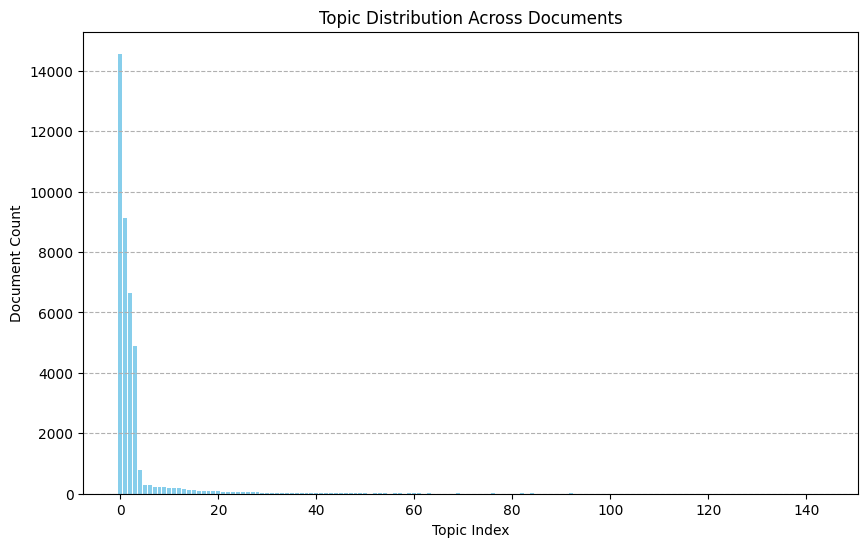

In [61]:
most_prevalent_topics = [max(hdp_model[doc], key=lambda x: x[1])[0] for doc in tweets_corpus]

topic_occurrences = np.bincount(most_prevalent_topics)

plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_occurrences)), topic_occurrences, color='skyblue')
plt.xlabel('Topic Index')
plt.ylabel('Document Count')
plt.title('Topic Distribution Across Documents')
plt.grid(axis='y', linestyle='--')
plt.show()


### 3.C

We are choosing topic 1 (assuming topics start from 0, we are selecting the second one), and based on the previous graph, lets name it

**2020 US Presidential Election** - This topic strongly emphasizes Trump, Biden, and the election, highlighting discussions or commentary on the political dynamics between these two figures in the context of an election.

In [64]:
topic = 1
doc_needed = [i for i,doc in enumerate(tweets_corpus) if hdp_model[doc][0][0] == topic]

<Axes: xlabel='date'>

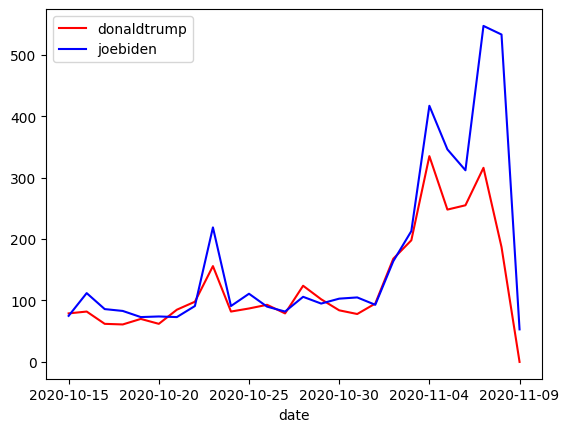

In [109]:
df_needed = election_tweets.iloc[doc_needed][['date','hashtag']]
df_needed = pd.concat([df_needed,pd.get_dummies(df_needed['hashtag'],dtype=float)],axis=1).drop(['hashtag'],axis=1)
df_needed = df_needed.groupby('date').sum()
df_needed.plot(color={'donaldtrump': 'red', 'joebiden': 'blue'})

**2020 US President Elections** time series graph

>There is a significant spike for both hashtags on or around November 3, which corresponds with the U.S. presidential election day. This indicates a heightened interest and discussion about both individuals on this date.

>While both topics have similar patterns, there are periods where one hashtag is mentioned more frequently than the other. For instance, "donaldtrump" appears to have higher peaks on certain days before the election compared to "joebiden". However, both see a dramatic increase around the election.


>The peaks might correspond to specific events, such as debates, rallies, or major news stories. Similarly, the troughs could represent days with less activity or fewer events related to the candidates.

>Overall, we can also see Biden followers had mode social media presence or support indicated by the higher peaks almost all the time over Donald Trump.



## Q 4

### 4.A

In [67]:
news_df = pd.read_csv("/content/drive/MyDrive/TAD/HW3_data/news_data.csv",delimiter=',',index_col=False)
news_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [90]:
political_news = news_df[news_df['category'] == 'POLITICS'].head(1000)
political_news.head()

,category,headline,authors,link,short_description,date
13,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26
14,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26
15,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26
16,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26
17,POLITICS,Ireland Votes To Repeal Abortion Amendment In ...,Laura Bassett,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...,2018-05-26


In [69]:
#performing the necessary preprocessing asked
def preprocess_q4(doc):
      ip_text = doc.translate(str.maketrans('', '', string.punctuation)).lower()
      tokens = word_tokenize(ip_text)
      stop_words = set(stopwords.words("english"))
      output = [word for word in tokens if word not in stop_words]
      return " ".join(output)
tfidf_vectorizer = TfidfVectorizer()
texts = political_news['headline']
q4_preprocessed = list(map(preprocess_q4, texts))
q4_dtm = tfidf_vectorizer.fit_transform(q4_preprocessed)
pd.DataFrame(q4_dtm.toarray(), columns=tfidf_vectorizer.get_feature_names_out(),index =range(len(q4_preprocessed)))

,100,100000,1140,11yearold,13,130000,15,150000,16,1929,...,yet,york,yorks,young,youre,youve,zinke,zippers,zuckerberg,zuckerbergs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
X = q4_dtm.toarray()
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

num_components = 500
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(X_standardized)

pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

politics_news = pd.concat([political_news, pca_df], axis=1)
politics_news.head()

,category,headline,authors,link,short_description,date,PC1,PC2,PC3,PC4,...,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500
13,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26,-0.058441,-0.412712,-0.089673,0.885322,...,0.030000,0.089668,-0.794694,-0.682560,0.263087,-1.029618,-0.010712,-0.411459,-0.437024,0.093303
14,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26,-0.111630,0.221145,-0.077667,-0.035989,...,0.287435,0.077078,-0.038659,-1.759456,-0.683411,-0.146478,-0.109008,-0.362648,0.204328,-0.938366
15,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26,0.019190,-0.250084,-0.113655,0.135318,...,1.970385,0.975230,1.165297,-0.202696,-5.708828,6.420210,-1.198082,1.962710,1.606209,-1.364366
16,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26,-0.155429,-0.083936,-0.175381,-0.222315,...,-0.056659,-0.424868,-0.328269,0.892282,-1.731843,-0.863944,0.791035,-3.001688,1.711554,2.217571
17,POLITICS,Ireland Votes To Repeal Abortion Amendment In ...,Laura Bassett,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...,2018-05-26,-0.139215,-0.198848,-0.182245,-0.209616,...,-3.728077,-2.630209,0.304412,0.663245,1.244902,-2.821293,0.443666,0.113127,-2.124328,2.851319


In [98]:
loadings = pca.components_[0]
features = tfidf_vectorizer.get_feature_names_out()

top_positive_loadings = features[np.argsort(loadings)][-5:]
print(f"The top 5 positive loadings are : {top_positive_loadings}")

top_negative_loadings = features[np.argsort(loadings)][:5]
print(f"The top 5 negative loadings are : {top_negative_loadings}")

The top 5 positive loadings are : ['fouryear' 'happy' 'colleges' 'universities' 'bachelor']
The top 5 negative loadings are : ['widens' 'rise' 'metro' 'figures' 'slight']


Here the Top 5 positive and negative loading of the PC1 are displayed.

The words are very interpretable.
The positive and negative from the loadings can be classified into news releated to college education and news related to metro fee rise.

### 4.B

In [99]:
def preprocess_q4_lsi(doc):
      ip_text = doc.translate(str.maketrans('', '', string.punctuation)).lower()
      tokens = word_tokenize(ip_text)
      stop_words = set(stopwords.words("english"))
      output = [word for word in tokens if word not in stop_words]
      return output
preprocessed_q4_lsi = list(map(preprocess_q4_lsi, texts))
common_dictionary_q4 = Dictionary(preprocessed_q4_lsi)
corpus = [common_dictionary_q4.doc2bow(text) for text in preprocessed_q4_lsi]

In [104]:
lsi = LsiModel(corpus = corpus, num_topics=10, id2word=common_dictionary_q4)

In [105]:
similarity_index = MatrixSimilarity(lsi[corpus])

def find_similar_words(target_word, num_results=5):
    target_word_vector = lsi[common_dictionary_q4.doc2bow([target_word])]
    similarities = similarity_index[target_word_vector]
    top_indices = np.argsort(similarities)[-num_results-1:-1]
    return [common_dictionary_q4[word_id] for word_id in top_indices]

similar_to_immigration = find_similar_words("immigration")
similar_to_police = find_similar_words("police")

print("Nearest to 'immigration':", similar_to_immigration)
print("Nearest to 'police':", similar_to_police)


Nearest to 'immigration': ['sets', 'jesus', 'arresting', 'neglect', 'historic']
Nearest to 'police': ['misspells', 'adult', 'read', 'actually', 'royal']


The nearest words according to the lsi model for "immigration" and "police" are given here.

For 'immigration', the five nearest tokens are ['sets', 'jesus', 'arresting', 'neglect', 'historic'].

>'arresting' could be relevant if the discussion is around illegal immigration and law enforcement.

>'neglect' might make sense if the context includes topics on how immigration issues are handled or ignored by authorities.
'historic' could be pertinent to the historical aspects of immigration patterns or legislation.

>'sets' is vague and could be relevant in a statistical or policy-setting context, but without additional context, its relevance is not clear.

>'jesus' seems out of place, unless the text data had specific religious contexts relating to immigration.

For 'police', the nearest tokens are ['misspells', 'adult', 'read', 'actually', 'royal'].

>'adult' could be relevant in discussions around policing adult behaviors or crimes.

>'read' might make sense in contexts discussing police reports or literacy in law enforcement.

>'actually' is a filler/adverb and its connection to 'police' isn't immediately clear without context.

>'royal' could be relevant in discussions about police in countries with monarchies or specific royal police forces.

>'misspells' seems quite out of place unless there was a specific context where spelling errors by the police were a topic of discussion.

### 4.C

In [106]:
glove_embeddings = api.load("glove-twitter-25")

glove_embeddings.most_similar(['police'],topn=5)

[==================================================] 100.0% 104.8/104.8MB downloaded


[('court', 0.8986871242523193),
 ('officials', 0.889279305934906),
 ('cops', 0.8803325891494751),
 ('suspect', 0.8759166598320007),
 ('arrest', 0.872292697429657)]

In [107]:
glove_embeddings.most_similar(['immigration'],topn=5)

[('obamacare', 0.9296227097511292),
 ('legislation', 0.9290511012077332),
 ('policy', 0.9231587052345276),
 ('reform', 0.9217007160186768),
 ('reforms', 0.9199499487876892)]

For 'immigration', the nearest neighbors are:

>>'obamacare': While this might seem initially off-topic, it's possible that in the dataset used to train the GloVe model, 'immigration' and 'obamacare' (the informal name for the Affordable Care Act) were frequently discussed together, possibly in the context of how immigration affects or is affected by healthcare policy.

>>'legislation': Immigration is a subject often associated with laws and legislative action.

>>'policy': Immigration policy is a central aspect of how countries manage and regulate the flow of people across borders.

>>'reform' and 'reforms': Discussions about immigration often involve talk of reforming existing laws and policies.

For 'police', the nearest neighbors are:

>>'court': Related to law enforcement and the justice system.

>>'officials': Can often be associated with government officials who work in public safety, including police.

>>'cops': A colloquial term for police officers.

>>'suspect': A person who is suspected of a crime is typically dealt with by the police.

>>'arrest': A direct action often taken by police in the enforcement of the law.


The nearest neighbors identified by the GloVe model show more meaningful connections to the words "immigration" and "police" than those from the LSA model. This difference in relevance could be due to the vast dataset the GloVe model was trained on, as opposed to the LSA model that utilized only 1,000 news articles. Additionally, the variation in results might stem from the distinct methodologies employed by the two models.